In [20]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


previous data process for 2023 BNL Feb beamline data 

modified to process 2022 Dec beamline data

7 peaks are used to calculate TC: 002, 100, 102, 103, 110, 112, 201 

plot 4 peak TC: 002,100,102,103

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lmfit
import Zn_peak_integration_lmfit_1degree_bg_7peaksTCcal_BNL2022Dec as XRD_lmfit 
import time
import re
from datetime import datetime
import datetime

In [22]:
def import_file(file_path, file): 

     filename = file_path + '\\' + file 

     dataframe=pd.read_csv(filename)
     data=dataframe.to_numpy()

     return dataframe


In [23]:
def fitting_7_peaks(dataframe, intervals): 
     # intervals= [(4.13,4.3), (4.4,4.64), (6.1,6.26), (7.6,8),(8.75,8.99),(9.21,9.4)]
     # 002, 100, 102, 103-110, 112, 201 

     # intervals= [(4.13,4.3), (4.4,4.64), (6.1,6.26), (7.6,8),(8.7,9.19),(9.21,9.4),(10.95,11.15),(11.85,12.3)]

     # 002, 100, 102, 103-110, 112-200, 201, 203, 210-211

     hint = [{'background_c0':151287 , 'background_c1':-20989, 'amplitude':5692, 
               'center':4.217, 'sigma':0.01, 'fraction':5e-07},
                                        
               {'background_c0':151287 , 'background_c1':-20989, 'amplitude':5692, 
               'center':4.518, 'sigma':0.01, 'fraction':5e-07},

               {'background_c0':151287 , 'background_c1':-20989, 'amplitude':5692, 
               'center':6.185, 'sigma':0.01, 'fraction':5e-07},

               {'background_c0':151287 , 'background_c1':-20989, 'amplitude1':5692,'center1':7.778,'sigma1':0.01,
               'fraction1':5e-07, 'amplitude2':5692, 'center2':7.831, 'sigma2':0.01,  'fraction2':5e-07},

               {'background_c0':151287 , 'background_c1':-20989, 'amplitude':5692,
               'center':8.901,'sigma':0.01,'fraction':5e-07},
               
               {'background_c0':151287 , 'background_c1':-20989, 'amplitude':5692, 
               'center':9.292, 'sigma':0.01, 'fraction':5e-07},
               
               ]
     df_params_all,df_best_fits_all, df_differences_all, df_integrals_all = XRD_lmfit.peak_intensities_lmfit(dataframe, intervals, hint)

     return df_params_all,df_best_fits_all, df_differences_all, df_integrals_all

In [24]:
# plot fiting result of each XRD pattern of in situ data 

def plot_each_fitting_XRD(dataframe, intervals,file_path,df_best_fits,df_differences): 
    timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

    for i in range(1,dataframe.shape[1]): 
        j=dataframe.shape[1]-i
        fig=plt.figure(figsize=(15,10))
        ax=fig.add_subplot(111)
        title=list(dataframe.columns.values)[i].split('obs_')[1].split('_primary')[0]
        plt.title(title, fontsize=15)
        plt.plot(dataframe.iloc[:,0],dataframe.iloc[:,i],linewidth=3)
        plt.xlim(3.5,12.5)
        for (start, stop) in intervals: 
            x=df_best_fits.iloc[:,0]
            xx=x[(start<=x) == (x<=stop)]
            y_simulation=df_best_fits
            yy_simulation=y_simulation[(start<=x) == (x<=stop)].iloc[:,j]
            y_difference=df_differences
            yy_difference=y_difference[(start<=x) == (x<=stop)].iloc[:,j]

            
            plt.plot(xx,yy_simulation,label='simulation',linewidth=2)
            plt.plot(xx,yy_difference,label='difference',linewidth=2)

            plt.legend()

        plt.savefig(file_path + '\\lmfit_1degree_bg_7hkl_1nelder_formula2area_reverse' +'\\lmfit_1degree_bg_7hkl_' + title + timestr + '.png', dpi=300)
        # plt.savefig(file_path + '\\lmfit_1degree_bg_' + title + timestr + '.svg', dpi=300, format='SVG')
        plt.close()
    


In [25]:
# extract deposition time from pattern name 

def extract_depo_time(dataframe, start_depo): 

     #start_depo=datetime.datetime(2023,2,24,7,7,49)

     time_change = datetime.timedelta(minutes=2,seconds=5)

     start_depo_real= start_depo-time_change

     time_series=XRD_lmfit.extract_time_abs(dataframe,start_depo_real)
     print(time_series)

     return time_series

In [26]:
# join deoisition time and integrals, and plot time_integrals figure and save plot

def join_time_integrals_plot(time_series,df_integrals,file_path,file): 

     left = time_series
     right= df_integrals    
     time_integrals=pd.merge(left,right,left_index=True,right_index=True,how="left")
     print(time_integrals)
     time_integrals.columns = ['Time','Time_real', "Time/min", "002 peak", 
                              "100 peak", "102 peak", "103 peak", "110 peak", 
                              "112 peak", "201 peak", 
                              ]    

     timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

     fig=plt.figure(figsize=(9,6))
     ax=fig.add_subplot(111)
     title='PeakArea_lmfit_' + file.split('.csv')[0] + timestr 
     plt.title(title, fontsize=10)
     # 002, 100, 102, 103-110, 112-200, 201 
     plt.scatter(time_integrals["Time/min"], time_integrals["002 peak"], label='002')
     plt.scatter(time_integrals["Time/min"], time_integrals["100 peak"], label='100')
     plt.scatter(time_integrals["Time/min"], time_integrals["102 peak"], label='102')
     plt.scatter(time_integrals["Time/min"], time_integrals["103 peak"], label='103')
     plt.scatter(time_integrals["Time/min"], time_integrals["110 peak"], label='110')
     plt.scatter(time_integrals["Time/min"], time_integrals["112 peak"], label='112')
     plt.scatter(time_integrals["Time/min"], time_integrals["201 peak"], label='201')


     plt.xlabel('Time/min',fontsize=12)
     plt.ylabel('Peak Area',fontsize=12)

     # plt.xlim(0,21)
     # plt.ylim(-10,2750)

     plt.legend()

     plt.savefig(file_path + '\\PeakArea_lmfit_1degree_bg_7hkl_' + file.split('.csv')[0] + timestr + '.png', dpi=300)

     return time_integrals 


In [27]:

#simulated_Zn = [1, 0.6262055, 2.83950711, 0.48685383]

def calculate_all_TC(time_integrals): 

     simulated_Zn = {"(002)": 1, "(100)": 0.623002, "(101)": 2.822881, "(102)": 0.481876, "(103)": 0.647973, 
                    "(110)": 0.424383, "(004)": 0.103752, "(112)": 0.510745, "(200)": 0.058331, "(201)": 0.318444,
                    "(104)": 0.092161, "(202)": 0.077218, "(203)": 0.145904, "(105)": 0.121085, "(114)": 0.157887,
                    "(210)": 0.032774,"(211)": 0.185132,"(204)": 0.0272}


     time_integrals_TC = XRD_lmfit.calculate_TC(time_integrals, simulated_Zn)

     return time_integrals_TC



In [28]:

def plot_time_TC(time_integrals_TC,file_path,file): 

     timestr = "_" + time.strftime("%Y%m%d-%H%M%S")
     
     title='PeakArea_lmfit_7hkl_' + file.split('.csv')[0] + timestr 

     integrals=time_integrals_TC

     fig=plt.figure(figsize=(9,6))
     ax=fig.add_subplot(111)
     plt.xlabel('Time/min',fontsize=12)
     ax.tick_params(width=2)
     for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(2)

     plt.ylabel('Texture Coefficient',fontsize=16)
     plt.xticks(fontsize=12)
     plt.yticks(fontsize=12)
     ax.set_ylim([0,2])

     plt.plot(integrals["Time/min"],(integrals["002 peak_TC"]),'o',label='002 TC')
     plt.plot(integrals["Time/min"],(integrals["100 peak_TC"]),'o',label='100 TC')
     plt.plot(integrals["Time/min"],(integrals["102 peak_TC"]),'o',label='102 TC')
     plt.plot(integrals["Time/min"],(integrals["103 peak_TC"]),'o',label='103 TC')
     # plt.plot(integrals["Time/min"],(integrals["110 peak_TC"]),'o',label='110 TC')
     # plt.plot(integrals["Time/min"],(integrals["112 peak_TC"]),'o',label='112 TC')
     # plt.plot(integrals["Time/min"],(integrals["201 peak_TC"]),'o',label='201 TC') 

     plt.legend(ncol=2,markerscale=2,frameon=False,fontsize=16)
     fig.suptitle(title, fontsize=12)
     plt.tight_layout()

     # plt.xlim(0,21)
     plt.ylim(0,2)
     plt.legend(loc='lower right')
     timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

     fig.savefig(file_path + '\\TC_lmfit_1degree_bg_7hkl_' + file.split('.csv')[0] + timestr + '.png', dpi=300)

In [29]:
# save fitting results 
def save_all_data(time_integrals_TC,df_best_fits,df_differences,df_params,file_path,file): 
    timestr = "_" + time.strftime("%Y%m%d-%H%M%S")
    with pd.ExcelWriter(file_path + '\\' + 'lmfit_1degree_bg_7hkl_' + file.split('.csv')[0] + timestr + '.xlsx') as writer:
    
        # use to_excel function and specify the sheet_name and index
        # to store the dataframe in specified sheet
        time_integrals_TC.to_excel(writer, sheet_name="time_integrals_TC", float_format='%.5f',index=False)
        df_best_fits.to_excel(writer, sheet_name="best_fits", float_format='%.5f',index=False)
        df_differences.to_excel(writer, sheet_name="differences", float_format='%.5f',index=False)
        df_params.to_excel(writer, sheet_name="params", float_format='%.5f',index=False)

In [30]:
def do_all(file_path, file, start_depo, intervals):
    
     dataframe=import_file(file_path, file)

     df_params_all,df_best_fits_all, df_differences_all, df_integrals_all = fitting_7_peaks(dataframe, intervals)

     plot_each_fitting_XRD(dataframe, intervals,file_path,df_best_fits_all,df_differences_all)

     time_series = extract_depo_time(dataframe, start_depo)

     time_integrals = join_time_integrals_plot(time_series,df_integrals_all,file_path,file)

     time_integrals_TC = calculate_all_TC(time_integrals)

     plot_time_TC(time_integrals_TC,file_path,file) 

     save_all_data(time_integrals_TC,df_best_fits_all,df_differences_all,df_params_all,file_path,file)

fitting interval:  [4.13, 4.3]
currently working on 10 th patterns of total 10 patterns


fitting interval:  [4.13, 4.3]
currently working on 9 th patterns of total 10 patterns


fitting interval:  [4.13, 4.3]
currently working on 8 th patterns of total 10 patterns


fitting interval:  [4.13, 4.3]
currently working on 7 th patterns of total 10 patterns


fitting interval:  [4.13, 4.3]
currently working on 6 th patterns of total 10 patterns


fitting interval:  [4.13, 4.3]
currently working on 5 th patterns of total 10 patterns


fitting interval:  [4.13, 4.3]
currently working on 4 th patterns of total 10 patterns


fitting interval:  [4.13, 4.3]
currently working on 3 th patterns of total 10 patterns


fitting interval:  [4.13, 4.3]
currently working on 2 th patterns of total 10 patterns


fitting interval:  [4.13, 4.3]
currently working on 1 th patterns of total 10 patterns


fitting interval:  [4.4, 4.64]
currently working on 10 th patterns of total 10 patterns


fitting interval:  

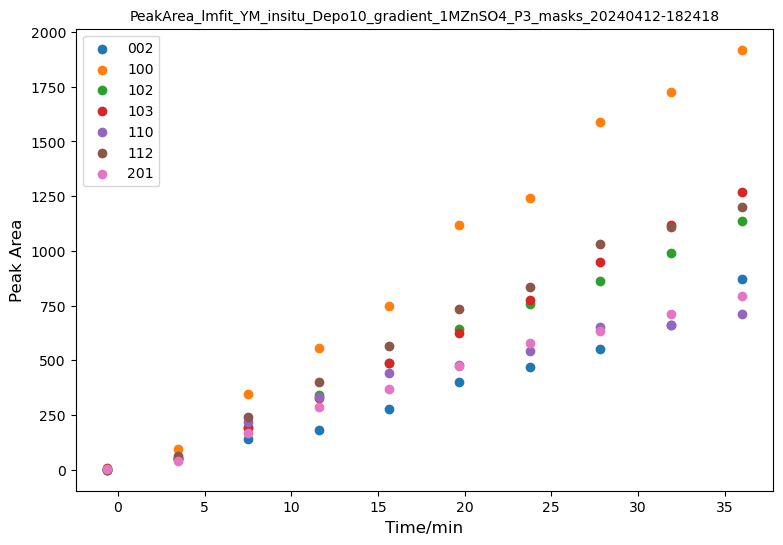

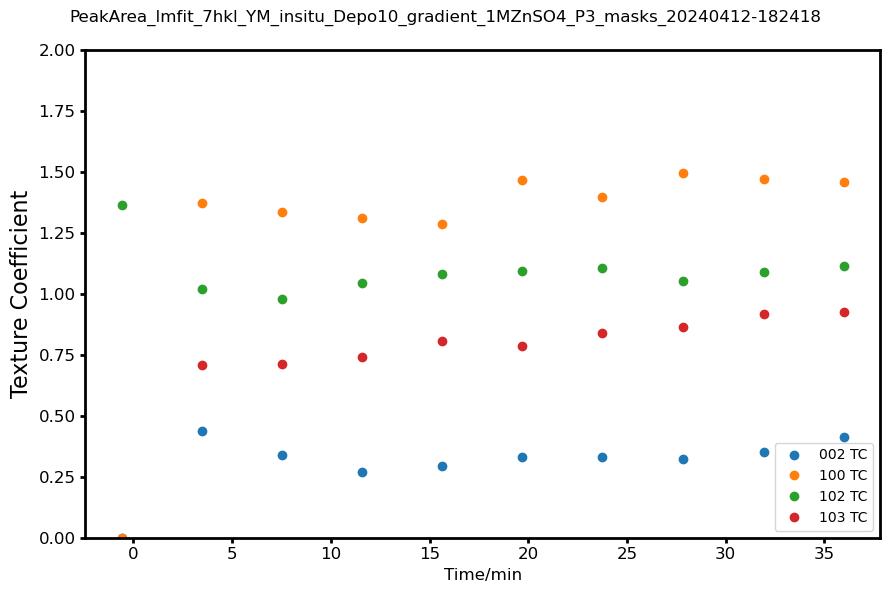

In [34]:
file_path=r'D:\BNL2022Dec\tiff_base\YM_insitu_Depo10_gradient_1MZnSO4'

file=r'YM_insitu_Depo10_gradient_1MZnSO4_P3_masks.csv'

start_depo=datetime.datetime(2022,12,6,6,30,50)

intervals= [(4.13,4.3), (4.4,4.64), (6.1,6.26), (7.6,8),(8.75,8.99),(9.21,9.4)]


do_all(file_path, file, start_depo, intervals)





In [ ]:
#plot TC from csv 

file_path=r'G:\BNL2023Feb\tiff_base\YM-depo1-60mA-Cu'

file=r'lmfit_1degree_bg_YM_depo_60mA_Cu_sub_2s.csv_20230223-125946.xlsx'

filename=file_path+'\\'+file

data = pd.ExcelFile(filename)

integrals = pd.read_excel(data, 'time_integrals_TC')

fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(111)
plt.xlabel('Time/min',fontsize=12)
ax.tick_params(width=2)
for axis in ['top','bottom','left','right']:
   ax.spines[axis].set_linewidth(2)
plt.ylabel('Texture Coefficient',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.plot(integrals["Time/min"],(integrals["002 peak_TC"]),'o',label='002 TC')
plt.plot(integrals["Time/min"],(integrals["100 peak_TC"]),'o',label='100 TC')
plt.plot(integrals["Time/min"],(integrals["102 peak_TC"]),'o',label='102 TC')
plt.plot(integrals["Time/min"],(integrals["103 peak_TC"]),'o',label='103 TC')
plt.plot(integrals["Time/min"],(integrals["110 peak_TC"]),'o',label='110 TC')
plt.plot(integrals["Time/min"],(integrals["112 peak_TC"]),'o',label='112 TC')
plt.plot(integrals["Time/min"],(integrals["200 peak_TC"]),'o',label='200 TC')
plt.plot(integrals["Time/min"],(integrals["201 peak_TC"]),'o',label='201 TC')
plt.plot(integrals["Time/min"],(integrals["203 peak_TC"]),'o',label='203 TC')
plt.plot(integrals["Time/min"],(integrals["210 peak_TC"]),'o',label='210 TC')
plt.plot(integrals["Time/min"],(integrals["211 peak_TC"]),'o',label='211 TC',c='b')

plt.legend(ncol=2,markerscale=2,frameon=False,fontsize=16)
fig.suptitle(title, fontsize=12)
plt.tight_layout()

ax.set_xlim([-0.1,16])
ax.set_ylim([0,2.5])

plt.legend(ncol=2,markerscale=2,frameon=False,fontsize=16)
title=file.split('.csv')[0]
fig.suptitle(title, fontsize=12)
plt.tight_layout()

timestr = "_" + time.strftime("%Y%m%d-%H%M%S")

fig.savefig(file_path + '\\TC_lmfit_1degree_bg_' + file.split('.csv')[0] + timestr + '.png', dpi=300)

